In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torchvision.utils as vutils

import numpy as np
import csv
import pandas as pd
import numpy as np
import glob
import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.image as mpimg

import torchvision
from torchvision.io import read_image

In [2]:
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
# !unzip '/home/sharifullina/thesis/datasets/CASIA-WebFace.zip'

In [5]:
data = []

labels_paths = glob.glob('/home/sharifullina/thesis/datasets/CASIA-WebFace/' + '*')
n_labels = len(labels_paths)

for i in range(n_labels):
    for j in range(len(glob.glob(labels_paths[i] + '/*.jpg'))):
        data.append([glob.glob(labels_paths[i] + '/*.jpg')[j], labels_paths[i].split('/')[-1]])


In [9]:
sample_data = data[:100000]

with open('/home/sharifullina/thesis/data/cGAN_25epochs_100000images.csv', 'w') as sample_f:
    writer = csv.writer(sample_f)
    writer.writerow(['image', 'label'])
    writer.writerows(sample_data)

# dataset

In [10]:
class CasiaDataset(Dataset):
    def __init__(self,
                 imgs_path,
                 csv_file,
                 transform
                ):
        self.imgs_path = imgs_path
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        self.data = self.data.sample(frac=1)
    
        image = Image.open(self.data.iloc[index, 0])

        if self.transform:
            image = self.transform(image)
        return image

In [12]:
transform = transforms.Compose([
                                transforms.CenterCrop((128, 128)), 
                                transforms.Grayscale(),
                                transforms.ToTensor()
                                ])

sample_dataset = CasiaDataset(imgs_path = '/home/sharifullina/thesis/datasets/CASIA-WebFace/',
                          csv_file = '/home/sharifullina/thesis/data/cGAN_25epochs_100000images.csv',
                          transform = transform)

sample_loader = DataLoader(sample_dataset, 
                    batch_size=64,
                    )

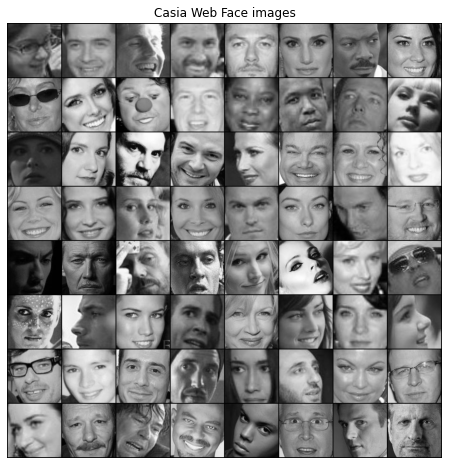

In [13]:
real_batch = next(iter(sample_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Casia Web Face images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device), padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [18]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super(Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect")
            if down
            else nn.ConvTranspose2d(in_channels, out_channels, 4, 2, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x


class Generator1(nn.Module):
    def __init__(self, in_channels=1, features=32):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(
            features * 2, features * 4, down=True, act="leaky", use_dropout=False
        )
        self.down3 = Block(
            features * 4, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down4 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down5 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.down6 = Block(
            features * 8, features * 8, down=True, act="leaky", use_dropout=False
        )
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1), nn.ReLU()
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up3 = Block(
            features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True
        )
        self.up4 = Block(
            features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False
        )
        self.up5 = Block(
            features * 8, features * 2, down=False, act="relu", use_dropout=False
        )
        self.up6 = Block(
            features * 4 , features, down=False, act="relu", use_dropout=False
        )
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        self.final_up = nn.Sequential(
            nn.ConvTranspose2d(features * 2, in_channels, kernel_size=4, stride=2, padding=1),
            # nn.Tanh(),
            nn.Sigmoid()
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        bottleneck = self.bottleneck(d6)
        up1 = self.up1(bottleneck)
        up2 = self.up2(torch.cat([up1, d6], 1))
        up3 = self.up3(torch.cat([up2, d5], 1))
        up4 = self.up4(torch.cat([up3, d4], 1))
        up5 = self.up5(torch.cat([up4, d3], 1))
        up6 = self.up6(torch.cat([up5, d2], 1))
        return self.final_up(torch.cat([up6, d1], 1))

In [19]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(CNNBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels, out_channels, 4, stride, 1, bias=False, padding_mode="reflect"
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.conv(x)


class Discriminator1(nn.Module):
    def __init__(self, in_channels=1, features=[32, 64, 128, 256]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels ,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                CNNBlock(in_channels, feature, stride=1 if feature == features[-1] else 2),
            )
            in_channels = feature

        layers.append(
            nn.Conv2d(
                in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"
            ),
        )
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        x = self.model(x)
        return x


# training model

In [20]:
lr = 3e-4
batch_size = 64
num_epochs = 25
n_noise = 256
n_critic = 1


In [21]:
discriminator = Discriminator1().to(device)
generator = Generator1().to(device)

criterion_gan = nn.BCELoss()
D_opt = torch.optim.Adam(discriminator.parameters(), lr = lr)
G_opt = torch.optim.Adam(generator.parameters(), lr = lr)
fixed_noise = torch.randn((batch_size, 1, 128, 128)).to(device)

In [22]:
writer_fake = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_25epochs_100000images/fake")
writer_real = SummaryWriter(f"/home/sharifullina/thesis/logs_cGAN_25epochs_100000images/real")

In [23]:
G_losses = []
D_losses = []
img_list = []

In [ ]:
generator.train()
discriminator.train()

for epoch in range(num_epochs):
    for idx, images in enumerate(sample_loader, 0):
    
        step = 0
        real_imgs = images.to(device)
        batch_size = real_imgs.size(0)
        noise = torch.randn(real_imgs.size(0), 1, 128, 128, device=device)

        D_opt.zero_grad()
        G_opt.zero_grad()

        fake = generator(noise)
        disc_real = discriminator(real_imgs)
        D_loss_1 = criterion_gan(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake)
        D_loss_2 = criterion_gan(disc_fake, torch.zeros_like(disc_fake))
        D_loss = (D_loss_1 + D_loss_2) / 2
        D_opt.zero_grad()
        D_loss.backward(retain_graph=True)
        D_opt.step()

        output = discriminator(fake)
        G_loss = criterion_gan(output, torch.ones_like(output))
        G_opt.zero_grad()
        G_loss.backward()
        G_opt.step()

        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        if idx % 100 == 0:
              print(f"Epoch [{epoch}/{num_epochs}] Batch {idx}/{len(sample_loader)} \
              Loss D: {D_loss:.4f}, loss G: {G_loss:.4f}")

        if idx % 100 == 0:
            with torch.no_grad():
                fake = generator(fixed_noise)
                data = real_imgs
                img_grid_real = torchvision.utils.make_grid(data, normalize = True)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize = True)
                writer_real.add_image("Real", img_grid_real, global_step=step)
                writer_fake.add_image("Fake", img_grid_fake, global_step=step)
            step += 1

Epoch [0/25] Batch 0/1563               Loss D: 0.7097, loss G: 0.7961
Epoch [0/25] Batch 100/1563               Loss D: 0.2067, loss G: 2.1460
Epoch [0/25] Batch 200/1563               Loss D: 0.0391, loss G: 4.7161
Epoch [0/25] Batch 300/1563               Loss D: 0.0322, loss G: 4.0916
Epoch [0/25] Batch 400/1563               Loss D: 0.0345, loss G: 4.2887
Epoch [0/25] Batch 500/1563               Loss D: 0.0149, loss G: 4.1269
Epoch [0/25] Batch 600/1563               Loss D: 0.0107, loss G: 4.3044
Epoch [0/25] Batch 700/1563               Loss D: 0.0060, loss G: 4.7447
Epoch [0/25] Batch 800/1563               Loss D: 0.0161, loss G: 6.6060
Epoch [0/25] Batch 900/1563               Loss D: 0.0057, loss G: 5.7036
Epoch [0/25] Batch 1000/1563               Loss D: 0.0019, loss G: 6.9000
Epoch [0/25] Batch 1100/1563               Loss D: 0.0038, loss G: 5.7499
Epoch [0/25] Batch 1200/1563               Loss D: 0.0046, loss G: 7.6533
Epoch [0/25] Batch 1300/1563               Loss D:

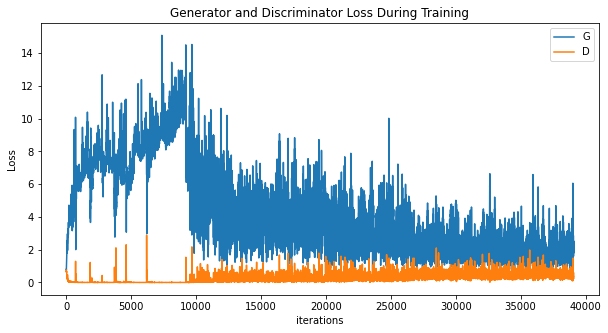

In [35]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/home/sharifullina/thesis/losses/loss_cGAN_25epochs_100000images.png')
plt.show()

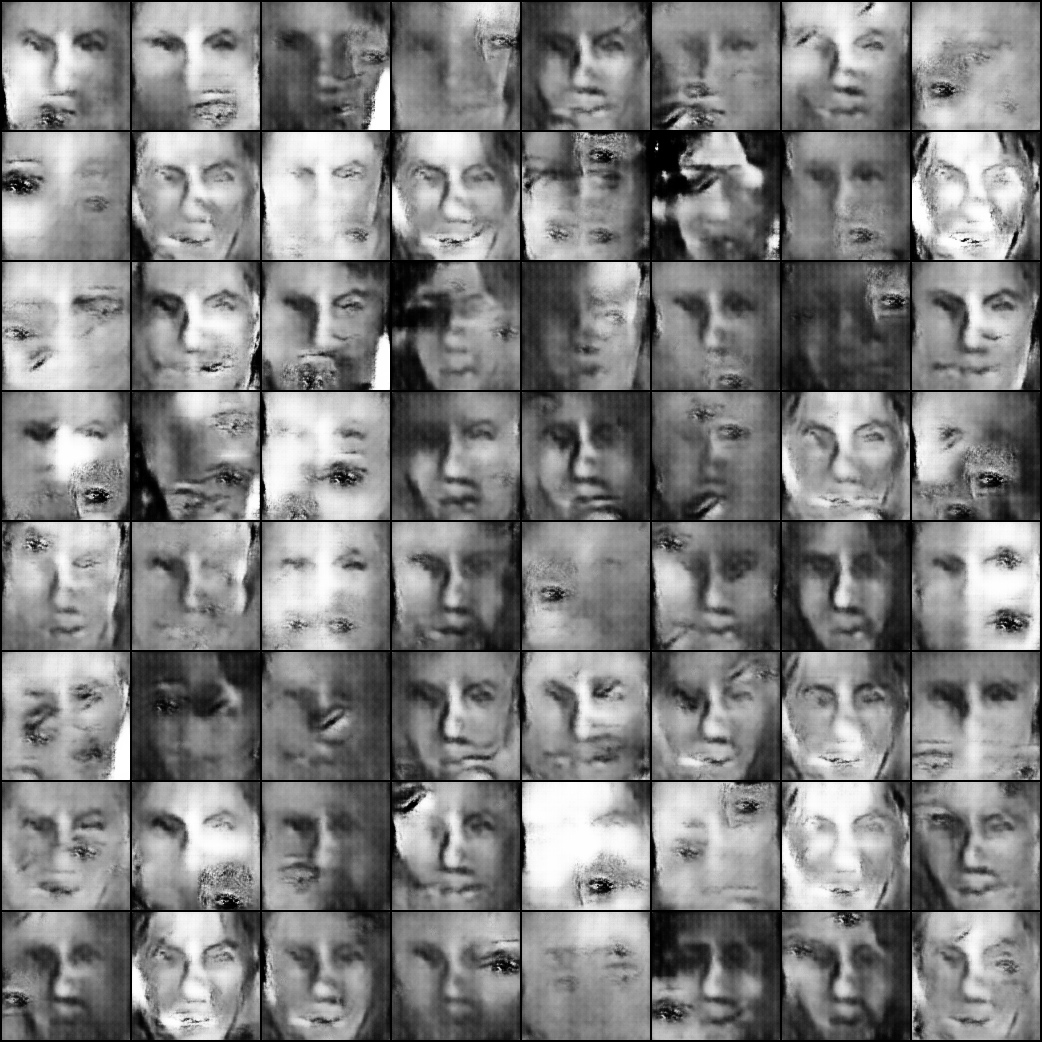

In [47]:
from IPython.display import display, Image
display(Image(filename='/home/sharifullina/thesis/fake_images/fake_images_cGAN_epochs25_100000images.png'))

In [45]:
# tensorboard --logdir logs --port=6666